In [1]:
import os
import pandas as pd
import numpy as np
from utils import its, plotline, plot_dual_indices
import warnings
warnings.filterwarnings('ignore')

FP = '../data/npr_cnn_textstat.csv.gz'
SAVEPATH = '../figs/'
os.makedirs(SAVEPATH, exist_ok=True) 

In [2]:
# (fold cell) Read & prep data
df = (pd.read_csv(FP)
      # Set date
      .assign(date=lambda df: df.date.str.replace('3007', '2007'))
      .assign(date=lambda df: pd.to_datetime(df.date, errors='coerce'),
              month=lambda df: [dt64.month for dt64 in df.date],
              year=lambda df: [dt64.year for dt64 in df.date],
              mthyr=lambda df: pd.to_datetime(df[['year', 'month']].assign(day=1)),
             )      
      # Drop outliers by length
      .pipe(lambda df: df.query(f'terms>{df.terms.quantile(q=0.01)}'))
      .pipe(lambda df: df.query(f'terms<{df.terms.quantile(q=0.99)}'))
      # Assign NPR or CNN
      .assign(npr=lambda df: np.where(df.id.str.contains('npr', case=False),1,0))
      .query('npr==1')
      .groupby(['mthyr']).mean().reset_index()
     )
df.head(3)

,mthyr,flesch_reading_ease,flesch_kincaid_grade,fog,smog,terms,uniqueterms,ttr,mtld,hdd,month,year,npr
0,2005-05-01,11.561931,21.947541,19.105683,14.661202,852.670310,347.908925,0.438927,91.849766,0.855462,5.0,2005.0,1
1,2005-06-01,11.364197,21.918028,19.092169,14.760563,827.721127,339.366197,0.441813,92.295927,0.855323,6.0,2005.0,1
2,2005-07-01,12.238950,21.839227,19.039797,14.446225,844.871087,345.635359,0.439805,93.919786,0.857621,7.0,2005.0,1


In [3]:
xrange=range(0,200,36)
xticklabels = range(2005,2021,3)

<AxesSubplot:title={'left':'Word Count per Article'}, xlabel='Publication year'>

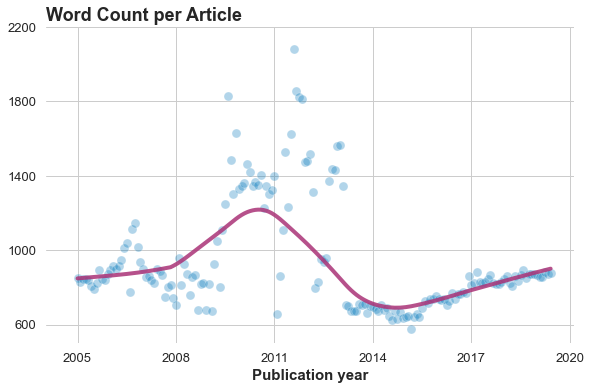

In [4]:
plotline(x=df.index, y=df.terms, 
         xrange=xrange, xticklabels=xticklabels,
         yrange=range(600,2300,400), 
         title='Word Count per Article', 
         savepath=os.path.join(SAVEPATH, 'npr_wordcount')
        )    

<AxesSubplot:title={'left':'Unique Words per Article'}, xlabel='Publication year'>

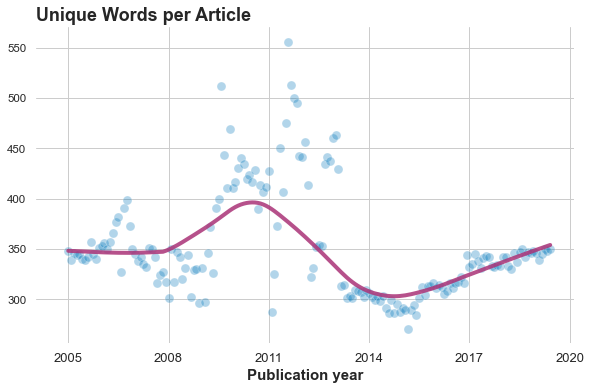

In [5]:
plotline(x=df.index, y=df.uniqueterms,
         xrange=xrange, xticklabels=xticklabels,
         title='Unique Words per Article', 
         savepath=os.path.join(SAVEPATH, 'npr_uniquewords')
        ) 

<AxesSubplot:title={'left':'Readability (Flesch Reading Ease)'}, xlabel='Publication year'>

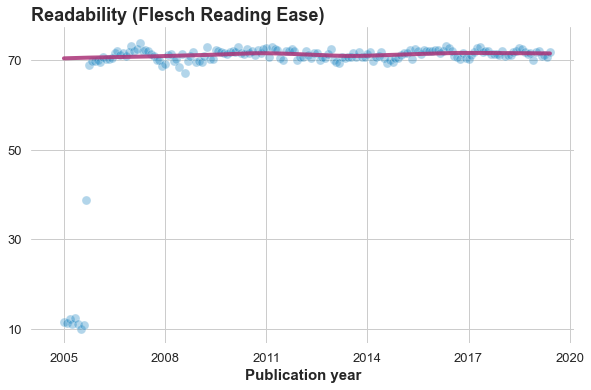

In [6]:
plotline(x=df.index, y=df.flesch_reading_ease,
         xrange=xrange, xticklabels=xticklabels,
         yrange=range(10, 80, 20), 
         title='Readability (Flesch Reading Ease)',
         savepath=os.path.join(SAVEPATH, 'npr_readability_flesch_ease'))    

<AxesSubplot:title={'left':'Lexical Richness (MTLD)'}, xlabel='Publication year'>

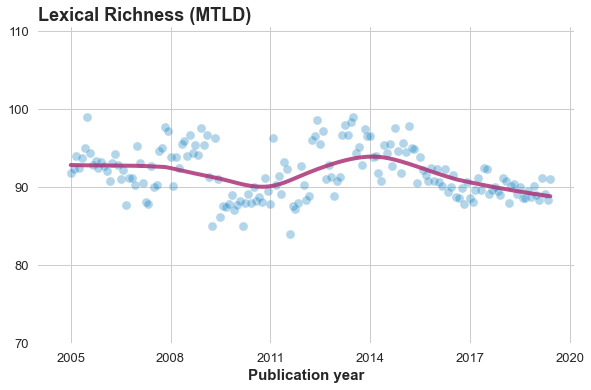

In [7]:
plotline(x=df.index, y=df.mtld, yrange=range(70,120,10), 
         xrange=xrange, xticklabels=xticklabels,         
         title='Lexical Richness (MTLD)', 
         savepath=os.path.join(SAVEPATH, 'npr_lexicalrichness_mtld'))    

In [8]:
# (fold cell) Prep indices
idf = (pd.read_csv(FP)
      # Set date
      .assign(date=lambda df: df.date.str.replace('3007', '2007'))
      .assign(date=lambda df: pd.to_datetime(df.date, errors='coerce'),
              month=lambda df: [dt64.month for dt64 in df.date],
              year=lambda df: [dt64.year for dt64 in df.date],
              mthyr=lambda df: pd.to_datetime(df[['year', 'month']].assign(day=1)),
             )      
      # Drop outliers by length
      .pipe(lambda df: df.query(f'terms>{df.terms.quantile(q=0.01)}'))
      .pipe(lambda df: df.query(f'terms<{df.terms.quantile(q=0.99)}'))
      # Assign NPR or CNN
      .assign(npr=lambda df: np.where(df.id.str.contains('npr', case=False),1,0))
      .query('npr==1')
      .groupby(['year']).mean().reset_index()
      .assign(
          iflesch_reading_ease=lambda df: df.apply(its, base=df.loc[0,'flesch_reading_ease'], x='flesch_reading_ease', axis=1),
          ismog=lambda df: df.apply(its, base=df.loc[0,'smog'], x='smog', axis=1),
          imtld=lambda df: df.apply(its, base=df.loc[0,'mtld'], x='mtld', axis=1),
          ittr=lambda df: df.apply(its, base=df.loc[0,'ttr'], x='ttr', axis=1),
          iword=lambda df: df.apply(its, base=df.loc[0,'terms'], x='terms', axis=1),
          iuniqueterms=lambda df: df.apply(its, base=df.loc[0,'uniqueterms'], x='uniqueterms', axis=1),
             )
     )
idf.head(3)

,year,flesch_reading_ease,flesch_kincaid_grade,fog,smog,terms,uniqueterms,ttr,mtld,hdd,month,npr,iflesch_reading_ease,ismog,imtld,ittr,iword,iuniqueterms
0,2005.0,11.360898,22.006250,19.167260,14.672950,831.426619,343.326164,0.440916,93.890745,0.856991,8.407389,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2006.0,67.586652,8.289862,9.664632,10.635921,902.350258,354.617384,0.433100,92.528644,0.856088,6.064544,1,494.905884,-27.513414,-1.450730,-1.772811,8.530355,3.288773
2,2007.0,71.908126,7.249415,8.827186,10.157884,967.591725,361.528493,0.427075,90.322401,0.855669,5.218970,1,532.944022,-30.771357,-3.800528,-3.139210,16.377285,5.301760


<AxesSubplot:xlabel='Publication year', ylabel='Percentage change since 2000'>

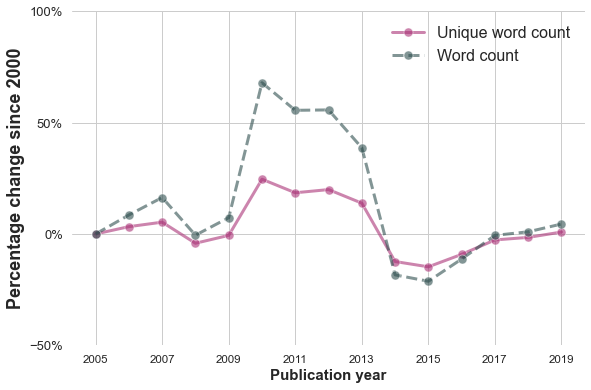

In [9]:
plot_dual_indices(x=idf.year, y1=idf.iuniqueterms, y2=idf.iword, 
                  label1='Unique word count', label2='Word count',
                  yrange=range(-50,150,50),
                  xrange=range(2005, 2020, 2),
                  ylabel='Percentage change since 2005',
                  savepath=os.path.join(SAVEPATH, 'npr_words_uniquewords')
                 )    

<AxesSubplot:title={'left':'Readability'}, xlabel='Publication year', ylabel='Percentage change since 2000'>

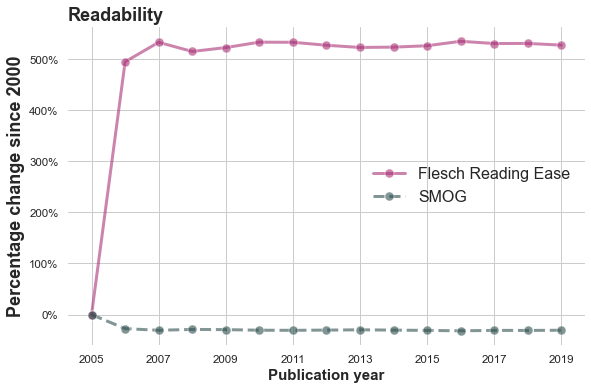

In [10]:
plot_dual_indices(x=idf.year, y1=idf.iflesch_reading_ease, y2=idf.ismog, 
                  label1='Flesch Reading Ease', label2='SMOG', title='Readability',
                  xrange=range(2005, 2020, 2),
                  ylabel='Percentage change since 2005',
                  savepath=os.path.join(SAVEPATH, 'npr_readability_index')
                 )    


<AxesSubplot:title={'left':'Lexical Richness'}, xlabel='Publication year', ylabel='Percentage change since 2000'>

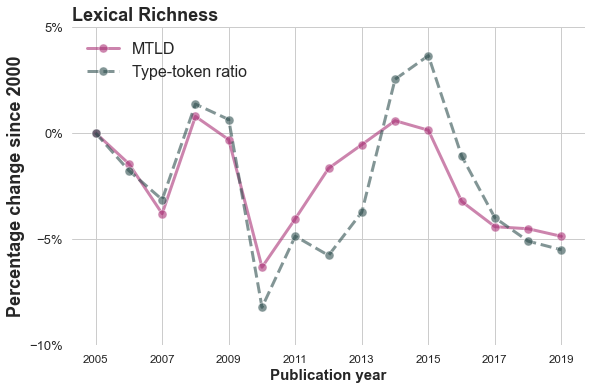

In [11]:
plot_dual_indices(x=idf.year, y1=idf.imtld, y2=idf.ittr, 
                  xrange=range(2005, 2020, 2),
                  yrange=range(-10,10,5), 
                  label1='MTLD', label2='Type-token ratio', title='Lexical Richness', 
                  ylabel='Percentage change since 2005',
                  savepath=os.path.join(SAVEPATH, 'npr_lexicalrichness_index')
                 )    
